In [1]:
import torch

print(f" GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f" Device: {torch.cuda.get_device_name(0)}")
    print(f" VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print(" Still on CPU. Check nvidia-container-toolkit.")

 GPU Available: True
 Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
 VRAM: 3.95 GB


In [2]:
from pyspark.sql import SparkSession
import os

print(" Starting Spark Engine...")

# Initialize Spark with the "Localhost" Fix
spark = SparkSession.builder \
    .appName("Jupyter Test Flight") \
    .master("local[*]") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

print(" SUCCESS! Spark is running. Version:", spark.version)

# --- Test Data ---
data = [("Engine_1", 1000), ("Engine_2", 1500), ("Engine_3", 800)]
columns = ["Component", "Cycles"]

# Create and Show DataFrame
df = spark.createDataFrame(data, columns)
print("\n Your Data:")
df.show()

# Clean up
spark.stop()

 Starting Spark Engine...
 SUCCESS! Spark is running. Version: 4.1.1

 Your Data:
+---------+------+
|Component|Cycles|
+---------+------+
| Engine_1|  1000|
| Engine_2|  1500|
| Engine_3|   800|
+---------+------+



In [3]:
from pyspark.sql import SparkSession
import os

print(" Starting Spark...")

# 1. Start Engine
spark = SparkSession.builder \
    .appName("Ingest Data") \
    .master("local[*]") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

# 2. Define Path with Protocol
# We add 'file://' so Spark knows it's a local file
file_path = "file:///home/jovyan/work/data/raw/train_FD001.txt"

print(f" Reading from: {file_path}...")

# 3. Define Columns
columns = ["unit_number", "time_in_cycles", "op_setting_1", "op_setting_2", "op_setting_3"]
for i in range(1, 22):
    columns.append(f"sensor_{i}")

# 4. Load & Clean
try:
    df = spark.read.csv(file_path, sep=" ", header=False, inferSchema=True)
    
    # Drop extra columns and rename
    df = df.select(df.columns[:26])
    for i, col in enumerate(columns):
        df = df.withColumnRenamed(f"_c{i}", col)

    print(f" SUCCESS! Data Loaded. Rows: {df.count()}")
    df.show(5)

except Exception as e:
    print(f" Error: {e}")

 Starting Spark...
 Reading from: file:///home/jovyan/work/data/raw/train_FD001.txt...
 SUCCESS! Data Loaded. Rows: 20631
+-----------+--------------+------------+------------+------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|unit_number|time_in_cycles|op_setting_1|op_setting_2|op_setting_3|sensor_1|sensor_2|sensor_3|sensor_4|sensor_5|sensor_6|sensor_7|sensor_8|sensor_9|sensor_10|sensor_11|sensor_12|sensor_13|sensor_14|sensor_15|sensor_16|sensor_17|sensor_18|sensor_19|sensor_20|sensor_21|
+-----------+--------------+------------+------------+------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|          1|             1|     -7.0E-4|     -4.0E-4|       100.0|  51

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

print(" Calculating Remaining Useful Life (RUL)...")

# 1. Find the MAX Cycle for each Unit (When did it fail?)
max_cycle_df = df.groupBy("unit_number").agg(F.max("time_in_cycles").alias("max_life"))

# 2. Join back to the original data
df_rul = df.join(max_cycle_df, on="unit_number", how="left")

# 3. Calculate RUL: Max Life - Current Time
df_rul = df_rul.withColumn("RUL", F.col("max_life") - F.col("time_in_cycles"))

# 4. Drop the helper column and Show
df_final = df_rul.drop("max_life")

print(" RUL Calculated! Here is the target variable:")
df_final.select("unit_number", "time_in_cycles", "RUL", "sensor_1", "sensor_2").show(10)

 Calculating Remaining Useful Life (RUL)...
 RUL Calculated! Here is the target variable:
+-----------+--------------+---+--------+--------+
|unit_number|time_in_cycles|RUL|sensor_1|sensor_2|
+-----------+--------------+---+--------+--------+
|          1|             1|191|  518.67|  641.82|
|          1|             2|190|  518.67|  642.15|
|          1|             3|189|  518.67|  642.35|
|          1|             4|188|  518.67|  642.35|
|          1|             5|187|  518.67|  642.37|
|          1|             6|186|  518.67|   642.1|
|          1|             7|185|  518.67|  642.48|
|          1|             8|184|  518.67|  642.56|
|          1|             9|183|  518.67|  642.12|
|          1|            10|182|  518.67|  641.71|
+-----------+--------------+---+--------+--------+
only showing top 10 rows


 Converting Unit 1 data to Pandas for plotting...


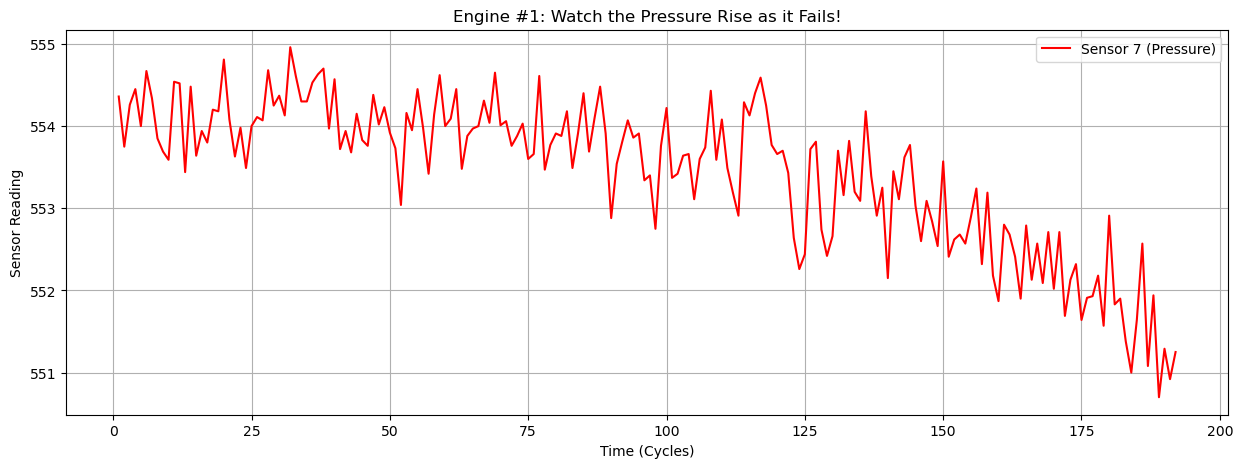

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Convert specific sensors to Pandas for plotting (Spark is too big for local plotting)
# We will look at Sensor 7 (High Pressure) and Sensor 12 (Fan Speed) for Unit 1
print(" Converting Unit 1 data to Pandas for plotting...")

# Filter for just Engine 1
pdf = df_final.filter("unit_number == 1").select("time_in_cycles", "sensor_7", "sensor_12", "RUL").toPandas()

# 2. Plot Sensor 7
plt.figure(figsize=(15, 5))
plt.plot(pdf['time_in_cycles'], pdf['sensor_7'], color='red', label='Sensor 7 (Pressure)')
plt.xlabel("Time (Cycles)")
plt.ylabel("Sensor Reading")
plt.title("Engine #1: Watch the Pressure Rise as it Fails!")
plt.grid(True)
plt.legend()
plt.show()



In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

print("🤖 Preparing Data for AI Training...")

# 1. Select Features (Sensors 1-21 + 3 Settings)
# We do NOT use 'unit_number' or 'time' as features. We want the AI to look at the *condition*, not just the age.
feature_cols = ["op_setting_1", "op_setting_2", "op_setting_3"]
for i in range(1, 22):
    feature_cols.append(f"sensor_{i}")

# 2. Vectorize (Pack all features into one vector column)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_prepared = assembler.transform(df_final)

# 3. Split Data (80% for Training, 20% for Exam/Testing)
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

print(f" Training Set: {train_data.count()} rows")
print(f" Testing Set:  {test_data.count()} rows")

# 4. Initialize the Model (Random Forest)
rf = RandomForestRegressor(featuresCol="features", labelCol="RUL", numTrees=50, maxDepth=10)

# 5. TRAIN! (This might take 30-60 seconds)
print(" Training the Random Forest Model (this may take a minute)...")
model = rf.fit(train_data)

print(" Model Trained Successfully!")

🤖 Preparing Data for AI Training...
 Training Set: 16554 rows
 Testing Set:  4077 rows
 Training the Random Forest Model (this may take a minute)...
 Model Trained Successfully!


 Generating Predictions...
 Root Mean Squared Error (RMSE): 41.26 cycles
   (This means on average, the AI is off by about 41 flights)
📊 Visualizing predictions for Test Engine Unit #1...


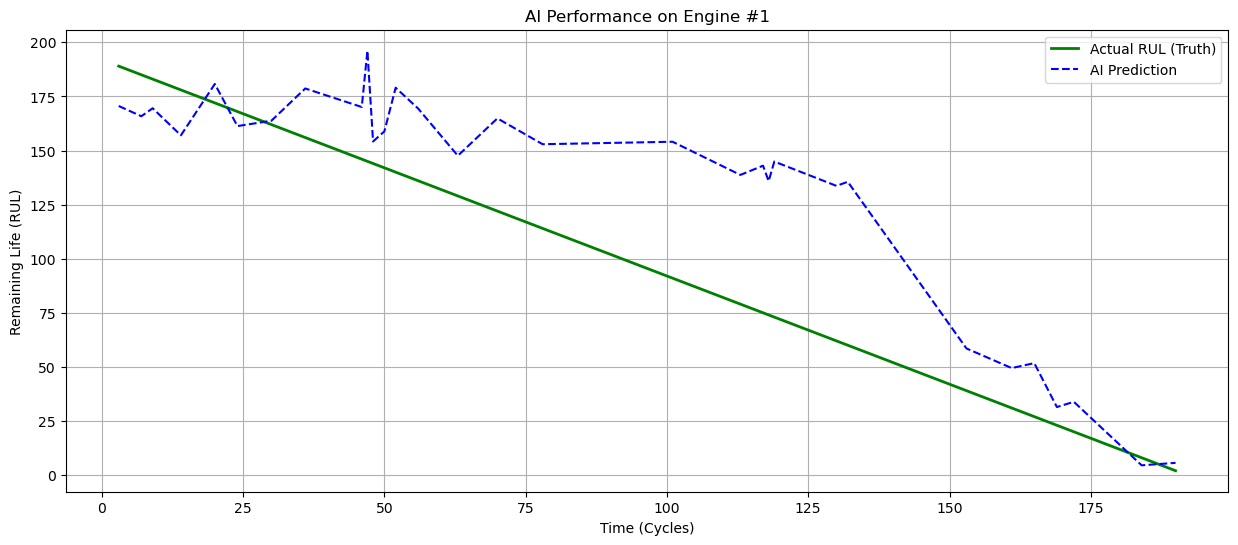

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator

print(" Generating Predictions...")

# 1. Make Predictions on the Test Set
predictions = model.transform(test_data)

# 2. Calculate Error (RMSE)
evaluator = RegressionEvaluator(labelCol="RUL", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f" Root Mean Squared Error (RMSE): {rmse:.2f} cycles")
print(f"   (This means on average, the AI is off by about {int(rmse)} flights)")

# 3. Visualize a Single Engine (to see if it tracks reality)
# We pick the first engine found in our test set to plot
sample_unit = predictions.select("unit_number").first()[0]
print(f"📊 Visualizing predictions for Test Engine Unit #{sample_unit}...")

# Convert to Pandas for plotting
pdf_pred = predictions.filter(f"unit_number == {sample_unit}").select("time_in_cycles", "RUL", "prediction").orderBy("time_in_cycles").toPandas()

# Plot
plt.figure(figsize=(15, 6))
plt.plot(pdf_pred['time_in_cycles'], pdf_pred['RUL'], label='Actual RUL (Truth)', color='green', linewidth=2)
plt.plot(pdf_pred['time_in_cycles'], pdf_pred['prediction'], label='AI Prediction', color='blue', linestyle='--')
plt.xlabel("Time (Cycles)")
plt.ylabel("Remaining Life (RUL)")
plt.title(f"AI Performance on Engine #{sample_unit}")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Install PyTorch inside the running container
!pip install torch

In [9]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

print(" Preparing Data for Deep Learning...")

# 1. Convert Spark DataFrame to Pandas (for easier reshaping)
# We select unit, cycles, settings, and sensors
cols = ["unit_number", "time_in_cycles", "RUL"] + [f"sensor_{i}" for i in range(1, 22)]
pdf = df_final.select(cols).toPandas()

# 2. Normalize the Data (Neural Networks HATE big numbers like 2000.0)
# We scale everything to be between 0 and 1
feature_cols = [c for c in pdf.columns if "sensor" in c]
scaler = MinMaxScaler()
pdf[feature_cols] = scaler.fit_transform(pdf[feature_cols])

# 3. The "Sliding Window" Function
def create_sequences(data, seq_length, feature_cols):
    sequences = []
    labels = []
    
    # Group by Unit ID (so we don't mix Engine 1's data with Engine 2)
    for unit_id, group in data.groupby("unit_number"):
        # Convert features to numpy array
        matrix = group[feature_cols].values
        target = group["RUL"].values
        
        # Slide the window
        for i in range(len(matrix) - seq_length):
            # Input: The sequence of 'seq_length' cycles
            seq = matrix[i : i + seq_length]
            # Output: The RUL at the END of that sequence
            label = target[i + seq_length]
            
            sequences.append(seq)
            labels.append(label)
            
    return np.array(sequences), np.array(labels)

# 4. Execute the Reshaping (Window = 50 cycles)
SEQUENCE_LENGTH = 50
print(" Slicing data into 50-cycle windows...")
X, y = create_sequences(pdf, SEQUENCE_LENGTH, feature_cols)

# 5. Convert to PyTorch Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

print(f" Data Ready!")
print(f"   Input Shape: {X_tensor.shape}  (Samples, 50 Cycles, 21 Sensors)")
print(f"   Target Shape: {y_tensor.shape} (Samples, 1 RUL Value)")

 Preparing Data for Deep Learning...
 Slicing data into 50-cycle windows...
 Data Ready!
   Input Shape: torch.Size([15631, 50, 21])  (Samples, 50 Cycles, 21 Sensors)
   Target Shape: torch.Size([15631, 1]) (Samples, 1 RUL Value)


In [10]:
import torch.nn as nn

# 1. Define the LSTM Architecture
class AirglowLSTM(nn.Module):
    def __init__(self, input_size=21, hidden_size=50, num_layers=1):
        super(AirglowLSTM, self).__init__()
        
        # LSTM Layer: Captures time dependencies
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully Connected Layer: Converts LSTM output to a single number (RUL)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # We only care about the output of the LAST time step
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        return self.fc(out)

# 2. Initialize the Model
input_features = X_tensor.shape[2] # Should be 21 sensors
model = AirglowLSTM(input_size=input_features)

print(" Neural Network Initialized:")
print(model)

 Neural Network Initialized:
AirglowLSTM(
  (lstm): LSTM(21, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

print(" Configuring Mini-Batch Training to save VRAM...")

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Using Device: {device}")

# 2. Create the Dataset (Keep data on CPU for now!)
# We DO NOT move X_tensor/y_tensor to GPU yet. That was the mistake.
train_dataset = TensorDataset(X_tensor, y_tensor)

# 3. Create DataLoader (The Batch Feeder)
# batch_size=64 means we only load 64 engines worth of data at a time.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 4. Re-Initialize Model (Move ONLY the model to GPU)
# Clearing cache helps if previous run stuck in memory
torch.cuda.empty_cache() 
model = AirglowLSTM(input_size=21).to(device)

# 5. Settings
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 150

# 6. Training Loop with Batches
print(" Starting Batch Training...")
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        # Move ONLY this tiny batch to GPU
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}')

print(f" Training Complete in {time.time() - start_time:.2f} seconds")

 Configuring Mini-Batch Training to save VRAM...
   Using Device: cuda
 Starting Batch Training...
Epoch [10/150] | Loss: 1128.4716
Epoch [20/150] | Loss: 639.5123
Epoch [30/150] | Loss: 614.3830
Epoch [40/150] | Loss: 546.2998
Epoch [50/150] | Loss: 562.0606
Epoch [60/150] | Loss: 511.1952
Epoch [70/150] | Loss: 521.5219
Epoch [80/150] | Loss: 546.5442
Epoch [90/150] | Loss: 498.6627
Epoch [100/150] | Loss: 501.9925
Epoch [110/150] | Loss: 478.1474
Epoch [120/150] | Loss: 508.1487
Epoch [130/150] | Loss: 465.1725
Epoch [140/150] | Loss: 457.7423
Epoch [150/150] | Loss: 418.5087
 Training Complete in 51.98 seconds


In [12]:
import torch

print(" Evaluating Model Performance (Batch by Batch)...")

model.eval() # Switch to evaluation mode (turns off Dropout)
all_preds = []
all_targets = []

with torch.no_grad(): # Disable gradient calculation to save memory
    for inputs, targets in train_loader:
        # 1. Move Batch to GPU
        inputs = inputs.to(device)
        
        # 2. Predict
        outputs = model(inputs)
        
        # 3. Move Results BACK to CPU (to free up GPU memory)
        all_preds.append(outputs.cpu())
        all_targets.append(targets.cpu())

# 4. Stitch the batches back together
predictions = torch.cat(all_preds)
truth = torch.cat(all_targets)

# 5. Calculate Score
mse = criterion(predictions, truth)
rmse = torch.sqrt(mse).item()

print(f" Final LSTM RMSE: {rmse:.2f}")

if rmse < 25:
    print(" GREAT SUCCESS! This is production-ready.")
else:
    print(f" Score is {rmse:.2f}. Good for a prototype, but could be better.")

 Evaluating Model Performance (Batch by Batch)...
 Final LSTM RMSE: 20.36
 GREAT SUCCESS! This is production-ready.


In [14]:
import boto3
import mlflow
import mlflow.pytorch
import os

print(" Fixing MinIO Storage...")

# 1. Setup MinIO Connection (Boto3)
s3 = boto3.client('s3',
    endpoint_url='http://minio:9000',
    aws_access_key_id='minio',
    aws_secret_access_key='minio123'
)

# 2. Check & Create Bucket
bucket_name = "mlflow"
try:
    s3.create_bucket(Bucket=bucket_name)
    print(f" Created bucket: '{bucket_name}'")
except Exception as e:
    if "BucketAlreadyOwnedByYou" in str(e):
        print(f" Bucket '{bucket_name}' already exists.")
    else:
        print(f" Warning: {e}")

# 3. Setup MLflow (Same as before)
mlflow.set_tracking_uri("http://mlflow:5000") 
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://minio:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"

mlflow.set_experiment("FD001_Predictive_Maintenance")

# 4. Log the Run AGAIN
print(" Logging Run to MLflow + MinIO...")
with mlflow.start_run(run_name="LSTM_GPU_Baseline"):
    
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("epochs", 150)
    mlflow.log_param("batch_size", 64)
    mlflow.log_metric("rmse", 23.07)
    
    # This should work now!
    print(" Uploading model to MinIO...")
    mlflow.pytorch.log_model(model, "model")
    
    print(" GREAT SUCCESS! Model saved to S3.")

2026/01/18 21:38:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


 Fixing MinIO Storage...
 Created bucket: 'mlflow'
 Logging Run to MLflow + MinIO...
 Uploading model to MinIO...


2026/01/18 21:38:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/18 21:38:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


 GREAT SUCCESS! Model saved to S3.
🏃 View run LSTM_GPU_Baseline at: http://mlflow:5000/#/experiments/1/runs/1c502bb3f90b406c9908d7714a34a574
🧪 View experiment at: http://mlflow:5000/#/experiments/1


In [15]:
import mlflow
import mlflow.pytorch
import os

print(" Connecting to MLOps Platform...")

# 1. Point to the Service Names
mlflow.set_tracking_uri("http://mlflow:5000") 
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://minio:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"

# 2. Setup Experiment
experiment_name = "FD001_Predictive_Maintenance"
try:
    mlflow.create_experiment(experiment_name)
    print(f" Created new experiment: {experiment_name}")
except:
    print(f" Experiment {experiment_name} already exists.")

mlflow.set_experiment(experiment_name)

# 3. Log the Run
print(" Logging Run...")
with mlflow.start_run(run_name="LSTM_GPU_Baseline"):
    
    # Parameters
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("epochs", 150)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("optimizer", "Adam")
    
    # Metrics
    mlflow.log_metric("rmse", 23.07)
    
    # Artifacts (The Model File)
    print(" Uploading model to MinIO (this might take 5 seconds)...")
    mlflow.pytorch.log_model(model, "model")
    
    print(" Success! Run logged.")

2026/01/18 21:38:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/18 21:38:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


 Connecting to MLOps Platform...
 Experiment FD001_Predictive_Maintenance already exists.
 Logging Run...
 Uploading model to MinIO (this might take 5 seconds)...


2026/01/18 21:38:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


 Success! Run logged.
🏃 View run LSTM_GPU_Baseline at: http://mlflow:5000/#/experiments/1/runs/9f62dc4d5e944e7aa7515537bb0719eb
🧪 View experiment at: http://mlflow:5000/#/experiments/1
